In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import os
import warnings
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from keras.models import load_model
import matplotlib.image as mpimg


Using TensorFlow backend.


In [2]:
warnings.filterwarnings("ignore")

In [3]:
model = load_model("model.h5")
data = pd.read_table("driving_dataset/data.txt",delimiter = ' ',names= ['files','angles'], dtype ={'results': np.float16})


W0504 23:22:46.249349 4529337792 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0504 23:22:46.261982 4529337792 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0504 23:22:46.377349 4529337792 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0504 23:22:46.378162 4529337792 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W05

In [4]:
def preprocess_img(path):
    img = mpimg.imread(path)
    part = img[150:,:,:]
    img = cv.cvtColor(part, cv.COLOR_RGB2YUV)
    img = cv.GaussianBlur(img,(3,3),0)
    img = cv.resize(img, (200,66))
    img = img/255
    return img

In [5]:
def new_generator(df, num):
    test_df = df.iloc[:num,:]
    while True:
        paths_series  =  "driving_dataset/" + test_df['files']

        imgs = np.asarray(list(map(preprocess_img, paths_series)))

        yield imgs

In [6]:
def write_angle(path, angle, count):
    image = Image.open(path)
    draw = ImageDraw.Draw(image)
    (x,y) = (50,50)

    message = 'degree = ' + str(angle)
    color = 'rgb(255, 255, 255)'
    draw.text((x, y), message, fill=color)
    name = 'a%d.png' % count
    image.save(name)
    
    return name

In [7]:
def make_video(video_name,file_names):
    frame = cv.imread(file_names[0])
    height, width = frame.shape[0], frame.shape[1]
    
    video = cv.VideoWriter(video_name + '.avi', 0, 1, (width,height))
    
    for file in file_names:
        video.write(cv.imread(file))

    video.release()


In [8]:
def whole(df, num_photos):
    model = load_model("model.h5")
        
    pred = model.predict_generator(new_generator(data,num_photos),1 )

    file_lst = data['files'].to_list()[:num_photos]
    image_folder = 'driving_dataset'
    count = 0
    new_names = []
    for file in file_lst:
        
        #1. Get the file
        path = os.path.join(image_folder, file)
        
        #2.Get rediction
        angle = pred[count][0]

        #3. Write the angle into image
        name = write_angle(path, angle, count)
        new_names.append(name)
        #Count
        count += 1
    make_video('result', new_names)

    return pred
    


In [9]:
pred = whole(data, 250)

# Evaluation

In [10]:
real = data.iloc[:250,:]['angles']

Text(0, 0.5, 'pred_angle')

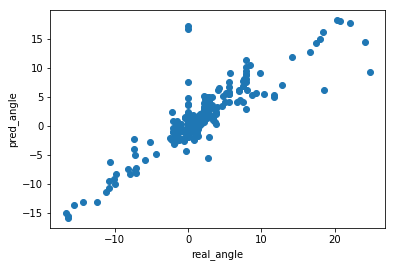

In [11]:
#250
plt.scatter(real,pred)
plt.xlabel('real_angle')
plt.ylabel('pred_angle')


# Finding Reasons behind inaccurate predictions

In [12]:
ind_larger15 = []
for i in range(len(pred)):
    if pred[i] > 15:
        ind_larger15.append(i)

In [13]:
data.iloc[ind_larger15, :]

,files,angles
124,124.jpg,18.05
125,125.jpg,18.45
126,126.jpg,0.00
127,127.jpg,20.27
128,128.jpg,20.77
129,129.jpg,22.08
130,130.jpg,0.00


In [14]:
img125 = cv.imread('driving_dataset/125.jpg')
img126 = cv.imread('driving_dataset/126.jpg')

16.111744


Text(0.5, 1.0, 'img125')

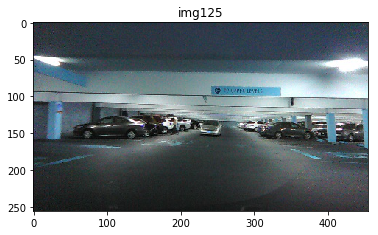

In [15]:
print(pred[125][0])
plt.imshow(img125)
plt.title('img125')

17.206934


Text(0.5, 1.0, 'img126')

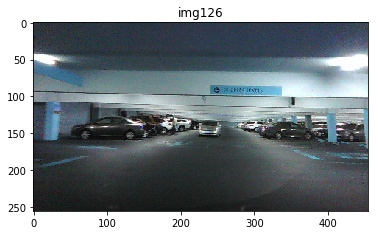

In [16]:
print(pred[126][0])
plt.imshow(img126)
plt.title('img126')